In [1]:
import os
import h5py
import itertools
import seaborn as sns
import numpy as np
from matplotlib import colors
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = "/home/kjakkala/neuralwave/data/CSI_48_mc_new/CSI_48_resample_2000_pca_dc_mean_norm_3.h5"

hf = h5py.File(data, 'r')
X_train = np.expand_dims(hf.get('X_train'), axis=-1)
X_test = np.expand_dims(hf.get('X_test'), axis=-1)
y_train = np.eye(48)[hf.get('y_train')]
y_test = np.eye(48)[hf.get('y_test')]
classes = np.array(hf.get('labels'))
hf.close()

model = load_model('/home/kjakkala/neuralwave/data/weights/CSI_48_mc_new/CSI_48_mc_3.h5')
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(20,20))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, annot=True, cbar=False, fmt=".2f", cmap=cmap)

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

In [ ]:
cnf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, title='Normalized confusion matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("confusion_matrix.png", bbox_inches='tight', dpi=150)
plt.show()

print(model.evaluate(X_test, y_test))

In [ ]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    #plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap=plt.cm.Blues):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [ ]:
plot_classification_report(classification_report(np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1))[:2647], "")
plt.savefig("classification_report.png", bbox_inches='tight', dpi=150)

In [3]:
layer_output_fun = K.function([model.layers[0].input], [model.layers[-1].output])
layer_output_0 = layer_output_fun([X_test[:150]])[0]
layer_output_0 = layer_output_0.reshape((layer_output_0).shape[0], -1)
layer_output_1 = layer_output_fun([X_test[150:]])[0]
layer_output_1 = layer_output_1.reshape((layer_output_1.shape[0], -1))
layer_output = np.concatenate([layer_output_0, layer_output_1])
print(layer_output.shape)

NUM_COLORS = 48
cm = plt.get_cmap('gist_rainbow')
base_colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

colors = []
y_true = np.argmax(y_test, 1)
for i in range(y_true.shape[0]):
    colors.append(base_colors[y_true[i]])

tsne = TSNE(n_components=2, random_state=0, n_iter=1000)
intermediates_tsne = tsne.fit_transform(layer_output)

(288, 48)


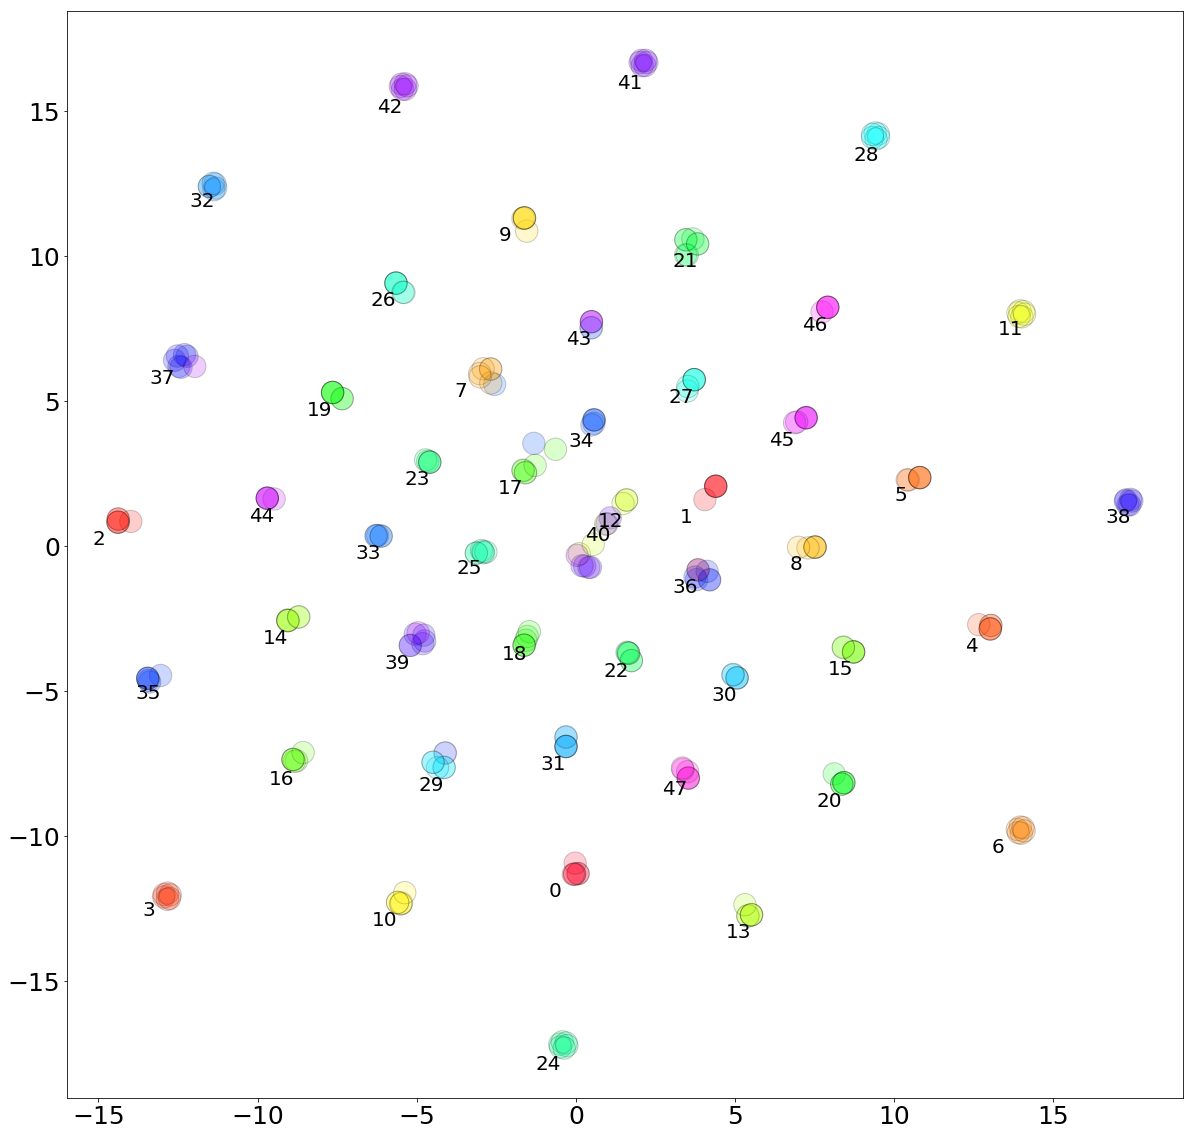

In [45]:
plt.figure(figsize=(20, 20))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], marker=".", color=colors, s=2000, edgecolor='black', alpha=0.2)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

for j in range(48):
    i = np.where(np.argmax(y_test, axis=-1) == j)[0][2]
    plt.text(intermediates_tsne[i,0]-0.8, intermediates_tsne[i,1]-0.8, str(j), color="k", fontsize=20)
    
plt.savefig("tsne_layer_last.png", bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
layer_output = K.function([model.layers[0].input], [model.layers[1].output])
layer_output = layer_output([X_train])[0]
layer_output = layer_output.reshape((layer_output.shape[0], -1))
print(layer_output.shape)

NUM_COLORS = 30
cm = plt.get_cmap('gist_rainbow')
base_colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

colors = []
y_true = np.argmax(y_train, 1)
for i in range(y_true.shape[0]):
    colors.append(base_colors[y_true[i]])

tsne = TSNE(n_components=2, random_state=0, n_iter=500)
intermediates_tsne = tsne.fit_transform(layer_output)

In [ ]:
plt.figure(figsize=(20, 20))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=colors, s=5000, edgecolor='black')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig("/home/kalvik/Documents/neuralwave/data/tsne_layer_first.png", bbox_inches='tight', dpi=150)
plt.show()